# Analysing a customer information dataset in the retail sector. 
This exercise goes through the creation of a basic pipeline from the basic data processing steps through to an analysis of customers into potential clusters. The aim of the analysis is customer segmentation to assist with targeted marketing.

License: CCO: Public Domain

## Installing dependancies

In [4]:
!pip install kneed

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split

from kmodes.kprototypes import KPrototypes

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance
from kneed import KneeLocator

from sklearn.decomposition import PCA

from tqdm import tqdm
import sys
import warnings
warnings.filterwarnings("ignore")

In [6]:
frTrain = 0.8       # Size of training set
RNDN = 77           # Random state
nk = 12             # Initial guess of amount of clusters

pd.set_option("display.precision", 2)
np.set_printoptions(precision=3, suppress=True)
pd.options.display.float_format = '{:.3f}'.format

## Accessing data

In [28]:
data = pd.read_csv("/content/drive/MyDrive/Colab Data/Bank Customer Churn Prediction.csv")

dfa0 = data.copy()
dfb1 = dfa0.copy()
dfb1.tail(2)

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
9998,15682355,772,Germany,Male,42,3,75075.310,2,1,0,92888.520,1
9999,15628319,792,France,Female,28,4,130142.790,1,1,0,38190.780,0


## Exploratory analysis and preprocessing

In [29]:
dfb1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       10000 non-null  int64  
 1   credit_score      10000 non-null  int64  
 2   country           10000 non-null  object 
 3   gender            10000 non-null  object 
 4   age               10000 non-null  int64  
 5   tenure            10000 non-null  int64  
 6   balance           10000 non-null  float64
 7   products_number   10000 non-null  int64  
 8   credit_card       10000 non-null  int64  
 9   active_member     10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


In [30]:
"""
One-hot encoding categorical variables
"""
# one-hot encoding: generate dummy variables from category variables
# transform and scale numerical variables
dfb2 = dfb1.copy()
dfb2.drop("customer_id", axis=1, inplace=True)

df_num = dfb2.select_dtypes(exclude='object')
df_cat = dfb2.select_dtypes(include='object')

for c in df_num.columns:
    pt = PowerTransformer()
    df_num.loc[:, c] = pt.fit_transform(np.array(df_num[c]).reshape(-1, 1))

# one-hot encoding
df_cat = pd.get_dummies(df_cat)
df_cat

# combine scaled numerical and categorical dummy variables in a dataframe
dfb2 = pd.concat([df_num, df_cat], axis=1)
dfb2.head(100)

# Standardize the data to have a mean of ~0 and a variance of 1
dfb3 = dfb2.copy()
dfb3 = StandardScaler().fit_transform(dfb3)

## Component Analysis

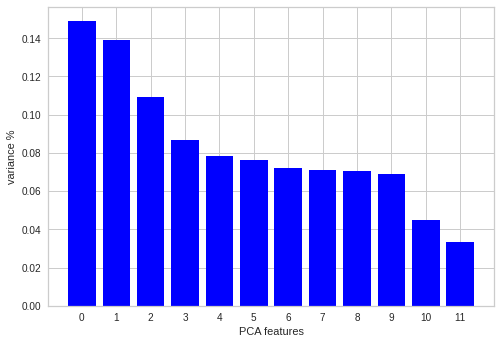

In [32]:
"""
Principle Component Analysis
"""
# principal components
pca = PCA(n_components=12)
res_pca = pca.fit_transform(dfb3)

# scree plot: variance drop-off after the fifth component; first 5 explain most of variance in data
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='blue')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)
plt.show()

Text(0, 0.5, 'PCA 2')

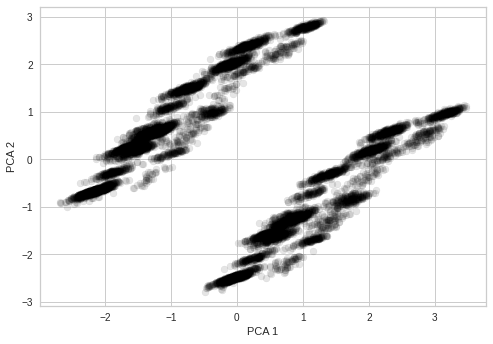

In [33]:
df_pca = pd.DataFrame(res_pca)
# No significant variance drop off after 11 Features

# plot first 2 components to see if there are any clear clusters
plt.scatter(df_pca[0], df_pca[1], alpha=.1, color='black')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

## KMeans Clustering

In [34]:
"""
Running KMeans with PCA components & compute inertia
"""
# kMeans with PCA components
ks = range(2, 10)
inertias_pca = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(df_pca.iloc[:,:])
    
    # Append the inertia to the list of inertias
    inertias_pca.append(model.inertia_)

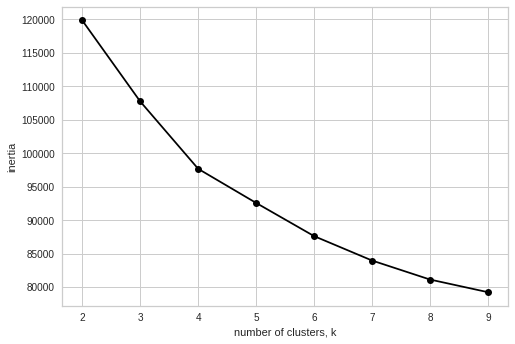

In [35]:
plt.plot(ks, inertias_pca, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

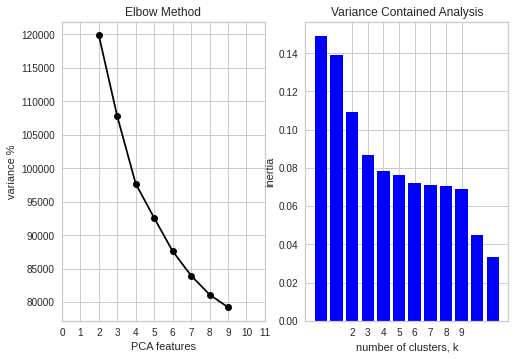

In [49]:
import numpy as np
import matplotlib.pyplot as plt

plt.subplot(1, 2, 1)
plt.plot(ks, inertias_pca, '-o', color='black')
plt.title('Elbow Method')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)


plt.subplot(1, 2, 2)
plt.bar(features, pca.explained_variance_ratio_, color='blue')
plt.title('Variance Contained Analysis')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)

plt.show()

In [36]:
"""
Determine number of clusters
"""
# inertia scores: confirm visual clue of elbow plot
# KneeLocator class will detect elbows if curve is convex; if concavem will detect knees
inertia_knee_b3 = KneeLocator(
        range(2,10), 
        inertias_pca, 
        S=0.1, curve="convex", direction="decreasing")

K_inertia_b3 = inertia_knee_b3.elbow   
print("elbow at k =", f'{K_inertia_b3:.0f} clusters')

# 4 Clusters is opitimal

elbow at k = 4 clusters


In [37]:
"""
Perform final KMeans
"""
# kMeans with clusters determined by elbow method
model = KMeans(n_clusters=4, random_state=RNDN)
clusters = model.fit_predict(dfb3)
dfb1.insert(0, "Cluster", clusters)  
dfb1.tail(20)

,Cluster,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
9980,3,15719276,741,Spain,Male,35,6,74371.490,1,0,0,99595.670,0
9981,0,15672754,498,Germany,Male,42,3,152039.700,1,1,1,53445.170,1
9982,0,15768163,655,Germany,Female,46,7,137145.120,1,1,0,115146.400,1
9983,1,15656710,613,France,Male,40,4,0.000,1,0,0,151325.240,0
9984,0,15696175,602,Germany,Male,35,7,90602.420,2,1,1,51695.410,0
9985,1,15586914,659,France,Male,36,6,123841.490,2,1,0,96833.000,0
9986,0,15581736,673,Germany,Male,47,1,183579.540,2,0,1,34047.540,0
9987,3,15588839,606,Spain,Male,30,8,180307.730,2,1,1,1914.410,0
9988,1,15589329,775,France,Male,30,4,0.000,2,1,0,49337.840,0
9989,3,15605622,841,Spain,Male,28,4,0.000,2,1,1,179436.600,0


In [39]:
def cluster_profile(df):
    dfc = df.groupby("Cluster").agg({
        "age": lambda x: x.value_counts().index[0], 
        "credit_score": lambda x: x.value_counts().index[0],
        "country": lambda x: x.value_counts().index[0],
        "gender": lambda x: x.value_counts().index[0],
        "balance": "median",
        "products_number": "median",
        "estimated_salary": "median",
        })

    #cluster_pies(df)
    return dfc

cluster_profile(dfb1)

,age,credit_score,country,gender,balance,products_number,estimated_salary
Cluster,,,,,,,
0,37,850,Germany,Male,119703.100,1.000,102397.220
1,37,850,France,Male,69413.440,1.000,99017.340
2,38,850,France,Female,47536.400,2.000,99504.030
3,35,850,Spain,Male,61710.440,2.000,99984.860
